In [2]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [11]:
!aws s3 cp 's3://sagemaker-us-east-1-266917422334/data/lost_objects.csv' ./data-folder/

download: s3://sagemaker-us-east-1-266917422334/data/lost_objects.csv to data-folder/lost_objects.csv


In [12]:
df = pd.read_csv("data-folder/lost_objects.csv")

In [13]:
df.shape

(2582, 8)

In [14]:
df.head()

,International Designator,NORAD Catalog Number,Satellite Name,Source,Launch Date,Launch Site,Object Type,Last Data
0,1960-009D,52.0,ECHO 1 DEB [MYLAR OBJ],US,1960-08-12,AFETR,DEB,1991-03-25T14:23:57.069312
1,1963-039C,692.0,VELA 1,US,1963-10-17,AFETR,PAY-,2024-11-06T17:09:09.800928
2,1964-040A,836.0,OPS 3662 (VELA 3),US,1964-07-17,AFETR,PAY-,2024-10-18T19:49:13.468512
3,1965-058A,1458.0,OPS 6577 (VELA 5),US,1965-07-20,AFETR,PAY-,2025-01-24T09:01:13.708704
4,1965-058B,1459.0,OPS 6564 (VELA 6),US,1965-07-20,AFETR,PAY-,2024-12-24T02:18:46.645344


In [16]:
df['Launch Site'].value_counts()

Launch Site
TYMSC    682
TAISC    614
PLMSC    469
AFETR    325
AFWTR    201
XICLF    112
FRGUI    107
WLPIS     26
SRILR     25
TANSC      4
JSC        4
SEAL       3
KSCUT      2
KWAJ       2
RLLB       2
DLS        1
ERAS       1
WSC        1
Name: count, dtype: int64

<Axes: xlabel='Source'>

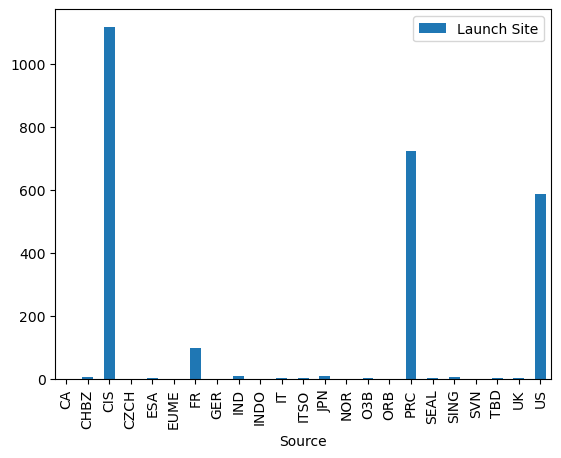

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

df[['Launch Site', 'Source']].groupby('Source').count().plot(kind = 'bar')

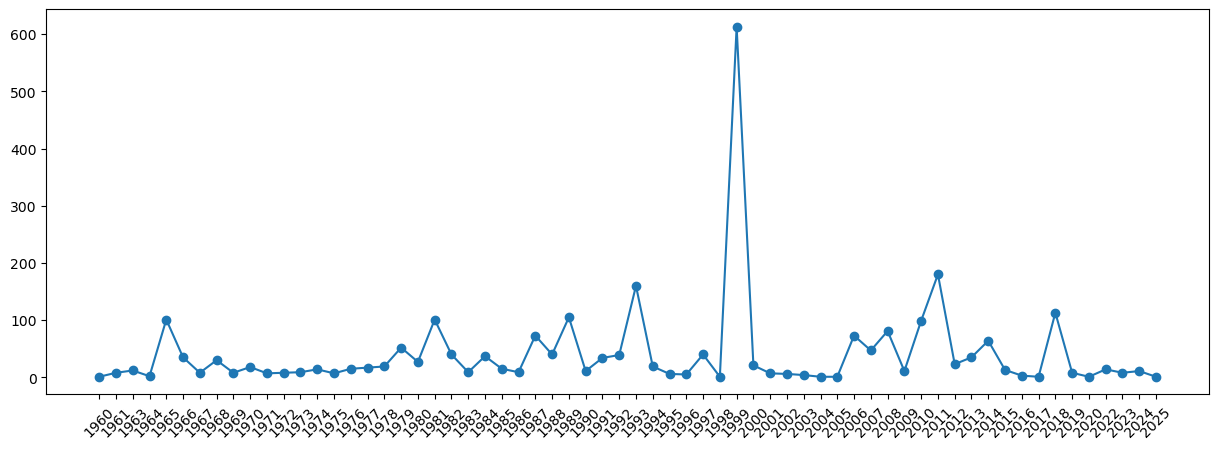

In [24]:
df['Launch Date'] = pd.to_datetime(df['Launch Date'])
launch_counts = df.groupby(df['Launch Date'].dt.to_period("Y"))['International Designator'].count()

launch_counts.index = launch_counts.index.astype(str)

plt.figure(figsize = (15,5))

plt.plot(launch_counts.index, launch_counts.values, marker = 'o', linestyle = '-')

plt.xticks(rotation = 45)

plt.show()

In [25]:
df['Object Type'].value_counts()

Object Type
DEB     2492
PAY-      37
R/B       25
PAY+      25
UNK        2
Name: count, dtype: int64

In [27]:
!pip install smclarify

In [28]:
from smclarify.bias import report
from typing import Dict
from collections import defaultdict

# Bias report for Deb object between countries

In [34]:
facet_columns = report.FacetColumn(name = 'Source')

label_column = report.LabelColumn(
    name = 'Object Type',
    series = df['Object Type'],
    positive_label_values=['DEB']
)

In [35]:
report.bias_report(
    df = df,
    facet_column=facet_columns,
    label_column=label_column,
    stage_type=report.StageType.PRE_TRAINING,
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

Data type of the elements in `positive_label_values` and in `label` must match. Converted positive_label_values from [nan] to ['nan']
CI metrics failed
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/smclarify/bias/report.py", line 323, in _categorical_metric_call_wrapper
    metric_value = smclarify.bias.metrics.call_metric(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/smclarify/bias/metrics/__init__.py", line 27, in call_metric
    return metric(**{key: kwargs[key] for key in inspect.signature(metric).parameters.keys()})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/smclarify/bias/metrics/pretraining.py", line 53, in CI
    raise ValueError("CI: facet set is empty. Check that x[facet] has non-zero length.")
ValueError: CI: facet set is empty. Check that x[facet] has non-zero length.
Data type of t

[{'value_or_threshold': 'US',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.5453137103020914},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.04749010516068697},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.006463397007098092},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.022462678522334804},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.047490105160687066},
   {'name': 'LP',
    'description': 'L-p Norm (LP)',
    'value': 0.06716115079676808},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.04749010516068702}]},
 {'value_or_threshold': 'CIS',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.13477924089852827},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in

In [36]:
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [37]:
from sagemaker import clarify

In [45]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [46]:
bias_report_output = "s3://{}/clarify-space".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path="data-folder/lost_objects.csv",
    s3_output_path=bias_report_output,
    label="Object Type",
    headers=df.columns.to_list(),
    dataset_type="text/csv",
)

In [47]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=['DEB'],
    facet_name="Source",
    facet_values_or_threshold=["US"],
)

In [48]:
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['International Designator', 'NORAD Catalog Number', 'Satellite Name', 'Source', 'Launch Date', 'Launch Site', 'Object Type', 'Last Data'], 'label': 'Object Type', 'label_values_or_threshold': ['DEB'], 'facet': [{'name_or_index': 'Source', 'value_or_threshold': ['US']}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': ['CI', 'DPL', 'KL', 'JS', 'LP', 'TVD', 'KS']}}}
INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2025-03-14-20-05-48-955


'Clarify-Pretraining-Bias-2025-03-14-20-05-48-955'

In [49]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

/tmp/ipykernel_205/604350854.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [54]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

In [51]:
from IPython.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [52]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-266917422334/Clarify-Pretraining-Bias-2025-03-14-20-05-48-955/input/dataset/lost_objects.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-266917422334/clarify-space/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-266917422334/clarify-space', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-20

In [53]:
running_processor.wait(logs=False)

.........................!

In [57]:
!aws s3 ls $bias_report_output/

2025-03-14 20:09:54       1951 analysis.json
2025-03-14 20:05:49        462 analysis_config.json
2025-03-14 20:09:54     527095 report.html
2025-03-14 20:09:54     254660 report.ipynb
2025-03-14 20:09:54     254244 report.pdf


In [58]:
!aws s3 cp --recursive $bias_report_output ./generated_bias_report/

download: s3://sagemaker-us-east-1-266917422334/clarify-space/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://sagemaker-us-east-1-266917422334/clarify-space/analysis.json to generated_bias_report/analysis.json
download: s3://sagemaker-us-east-1-266917422334/clarify-space/report.ipynb to generated_bias_report/report.ipynb
download: s3://sagemaker-us-east-1-266917422334/clarify-space/report.pdf to generated_bias_report/report.pdf
download: s3://sagemaker-us-east-1-266917422334/clarify-space/report.html to generated_bias_report/report.html
